In [136]:
import json
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
import re, string
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau


import warnings
warnings.filterwarnings("ignore")

### 0. Data Preprocessing

In [137]:
df= pd.read_json('train2.json')
df.head(5)

,text,value
0,most # funny quotes : 21 snarky and # funny qu...,1
1,spurs # creativethinking ! <url>,1
2,<user> thanks for showing up for our appointme...,1
3,only a hardcore fan of sir jonny sins will get...,1
4,haha . # lol,1


In [138]:
df[df.value == 0].head(5)

,text,value
1782,early at a local meet ; milling through # fc20...,0
1783,wow i look happy emoji_21,0
1784,blonder,0
1785,the number of kilometers you have to run to bu...,0
1786,snap saw it first emoji_8,0


In [139]:
df.value.value_counts()

0    14784
1    14256
Name: value, dtype: int64

In [140]:
df['text_len'] = df.text.apply(lambda x: len(x.split()))

In [141]:
sarcastic = df[df.value == 1]
legit = df[df.value == 0]

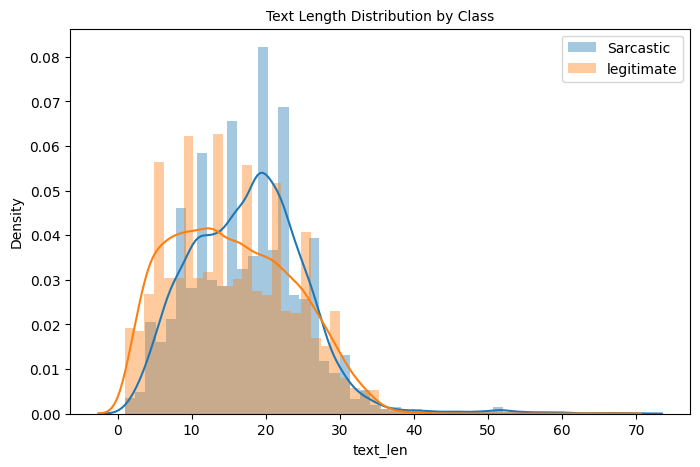

In [142]:
plt.figure(figsize=(8,5))
sns.distplot(sarcastic.text_len, hist= True, label= 'Sarcastic')
sns.distplot(legit.text_len, hist= True, label= 'legitimate')
plt.legend()
plt.title('Text Length Distribution by Class', fontsize = 10)
plt.show()

In [143]:
def clean_text(tweet):
    """
    This function receives a tweet and returns a clean sentence
    """
    tweet = tweet.lower()
    tweet = re.sub("\\n", "", tweet)

    # Split the tweet into words
    words = list(tweet.split())

    # Initialize WordNetLemmatizer
    lem = WordNetLemmatizer()

    # Lemmatize each word (assuming it's a verb, you can adjust the POS tag as needed)
    words = [lem.lemmatize(word, "v") for word in words]

    # Remove punctuations
    words = [w for w in words if w not in punctuations]

    # Optionally, remove stop words
    # words = [w for w in words if w not in stop_words]

    # Optionally, remove non-alphabetic characters
    # words = [''.join(x for x in w if x.isalpha()) for w in words]

    # Join the cleaned words back into a sentence
    clean_tweet = " ".join(words)

    return clean_tweet

In [144]:
import nltk
nltk.download('stopwords')
lem = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
punctuations = string.punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bhaskarruthvik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [145]:
import nltk
nltk.download('wordnet')
df['cleantext'] = df.text.apply(lambda text: clean_text(text))
df.head(5)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bhaskarruthvik/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,value,text_len,cleantext
0,most # funny quotes : 21 snarky and # funny qu...,1,23,most funny quote 21 snarky and funny quote fun...
1,spurs # creativethinking ! <url>,1,5,spur creativethinking <url>
2,<user> thanks for showing up for our appointme...,1,10,<user> thank for show up for our appointment t...
3,only a hardcore fan of sir jonny sins will get...,1,21,only a hardcore fan of sir jonny sin will get ...
4,haha . # lol,1,4,haha lol


In [146]:
df.groupby(['value']).text_len.mean()

value
0    15.476190
1    17.619529
Name: text_len, dtype: float64

In [147]:
df.groupby(['value']).text_len.max()

value
0    67
1    70
Name: text_len, dtype: int64

In [148]:
tweet = df['text']
labels = df['value']

In [149]:
tweet

0        most # funny quotes : 21 snarky and # funny qu...
1                         spurs # creativethinking ! <url>
2        <user> thanks for showing up for our appointme...
3        only a hardcore fan of sir jonny sins will get...
4                                            haha .  # lol
                               ...                        
29035                such a good read emoji_7810 emoji_238
29036    this is some people 's living conditions , alw...
29037    winner - seungyoon ( simple ) - rt if u save -...
29038    # theresistance # indivisible # unitedagainsth...
29039    ok but concept : kravitz passing notes between...
Name: text, Length: 29040, dtype: object

In [150]:
train_sentences = tweet
train_labels = labels

In [151]:
train_labels.value_counts()

0    14784
1    14256
Name: value, dtype: int64

### 0.1 Test Sentences

In [152]:
df_test = df= pd.read_json('test.json')
df_test.head(5)

,text,value
0,i am guessing # netflix no longer lets you gra...,1
1,it 's the insensitive strikeouts at suntrust p...,1
2,"following the path of the river calder , so .....",1
3,# westernsahara # authority has no lessons 2ge...,1
4,hey <user> great sale !,1


In [153]:
df_test.value.value_counts()

0    1404
1    1005
Name: value, dtype: int64

In [154]:
df_test['text_len'] = df_test.text.apply(lambda x: len(x.split()))

In [155]:
sarcastic = df_test[df_test.value == 1]
legit = df_test[df_test.value == 0]

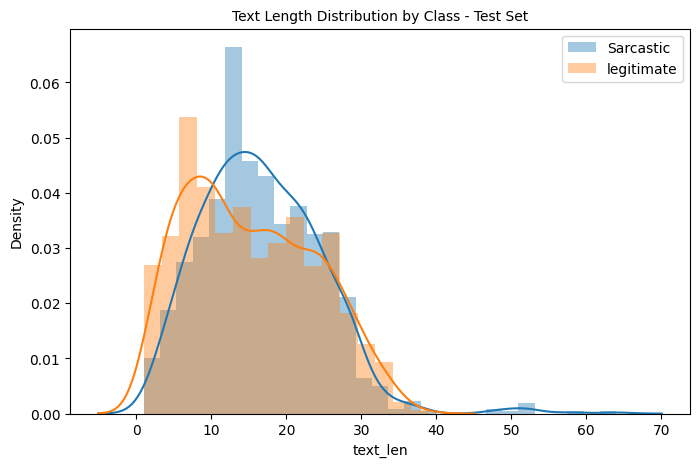

In [156]:
plt.figure(figsize=(8,5))
sns.distplot(sarcastic.text_len, hist= True, label= 'Sarcastic')
sns.distplot(legit.text_len, hist= True, label= 'legitimate')
plt.legend()
plt.title('Text Length Distribution by Class - Test Set', fontsize = 10)
plt.show()

In [157]:
import nltk
nltk.download('wordnet')
df_test['cleantext'] = df_test.text.apply(lambda text: clean_text(text))
df_test.head(5)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bhaskarruthvik/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,value,text_len,cleantext
0,i am guessing # netflix no longer lets you gra...,1,24,i be guess netflix no longer let you grab scre...
1,it 's the insensitive strikeouts at suntrust p...,1,13,it 's the insensitive strikeouts at suntrust p...
2,"following the path of the river calder , so .....",1,15,follow the path of the river calder so ... gri...
3,# westernsahara # authority has no lessons 2ge...,1,21,westernsahara authority have no lessons 2get f...
4,hey <user> great sale !,1,5,hey <user> great sale


In [158]:
df_test.groupby(['value']).text_len.mean()

value
0    15.299145
1    16.723383
Name: text_len, dtype: float64

In [159]:
df_test.groupby(['value']).text_len.max()

value
0    39
1    64
Name: text_len, dtype: int64

In [160]:
tweet_test = df_test['text']
labels_test = df_test['value']

In [161]:
test_sentences= tweet_test
test_labels = labels_test

In [162]:
max_words = 20000     # how many unique words to use (i.e num rows in embedding vector)
max_len = 60       # max number of words in a headline to use
oov_token = '<00V>'    # for the words which are not in training samples
padding_type = 'post'   # padding type
trunc_type = 'post'    # truncation for headlines longer than max length
embed_size = 64    # how big is each word vector

In [163]:
tokenizer = Tokenizer(num_words=max_words, oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

In [164]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [165]:
train_sequences

array([[  135,    21,    57, ...,     0,     0,     0],
       [ 3533, 15355,     5, ...,     0,     0,     0],
       [    4,    97,    13, ...,     0,     0,     0],
       ...,
       [  658,     1,  1646, ...,     0,     0,     0],
       [  931,  3697, 14995, ...,     0,     0,     0],
       [  526,    53,  2837, ...,     0,     0,     0]], dtype=int32)

### 1. ANN

In [92]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 60, 64)            1280000   
                                                                 
 global_max_pooling1d_14 (G  (None, 64)                0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_28 (Dense)            (None, 16)                1040      
                                                                 
 dropout_14 (Dropout)        (None, 16)                0         
                                                                 
 dense_29 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1281057 (4.89 MB)
Trainable params: 1281057 (4.89 MB)
Non-trainable params: 0 (0.00 Byte)
_______________

76/76 [==============================] - 0s 385us/step


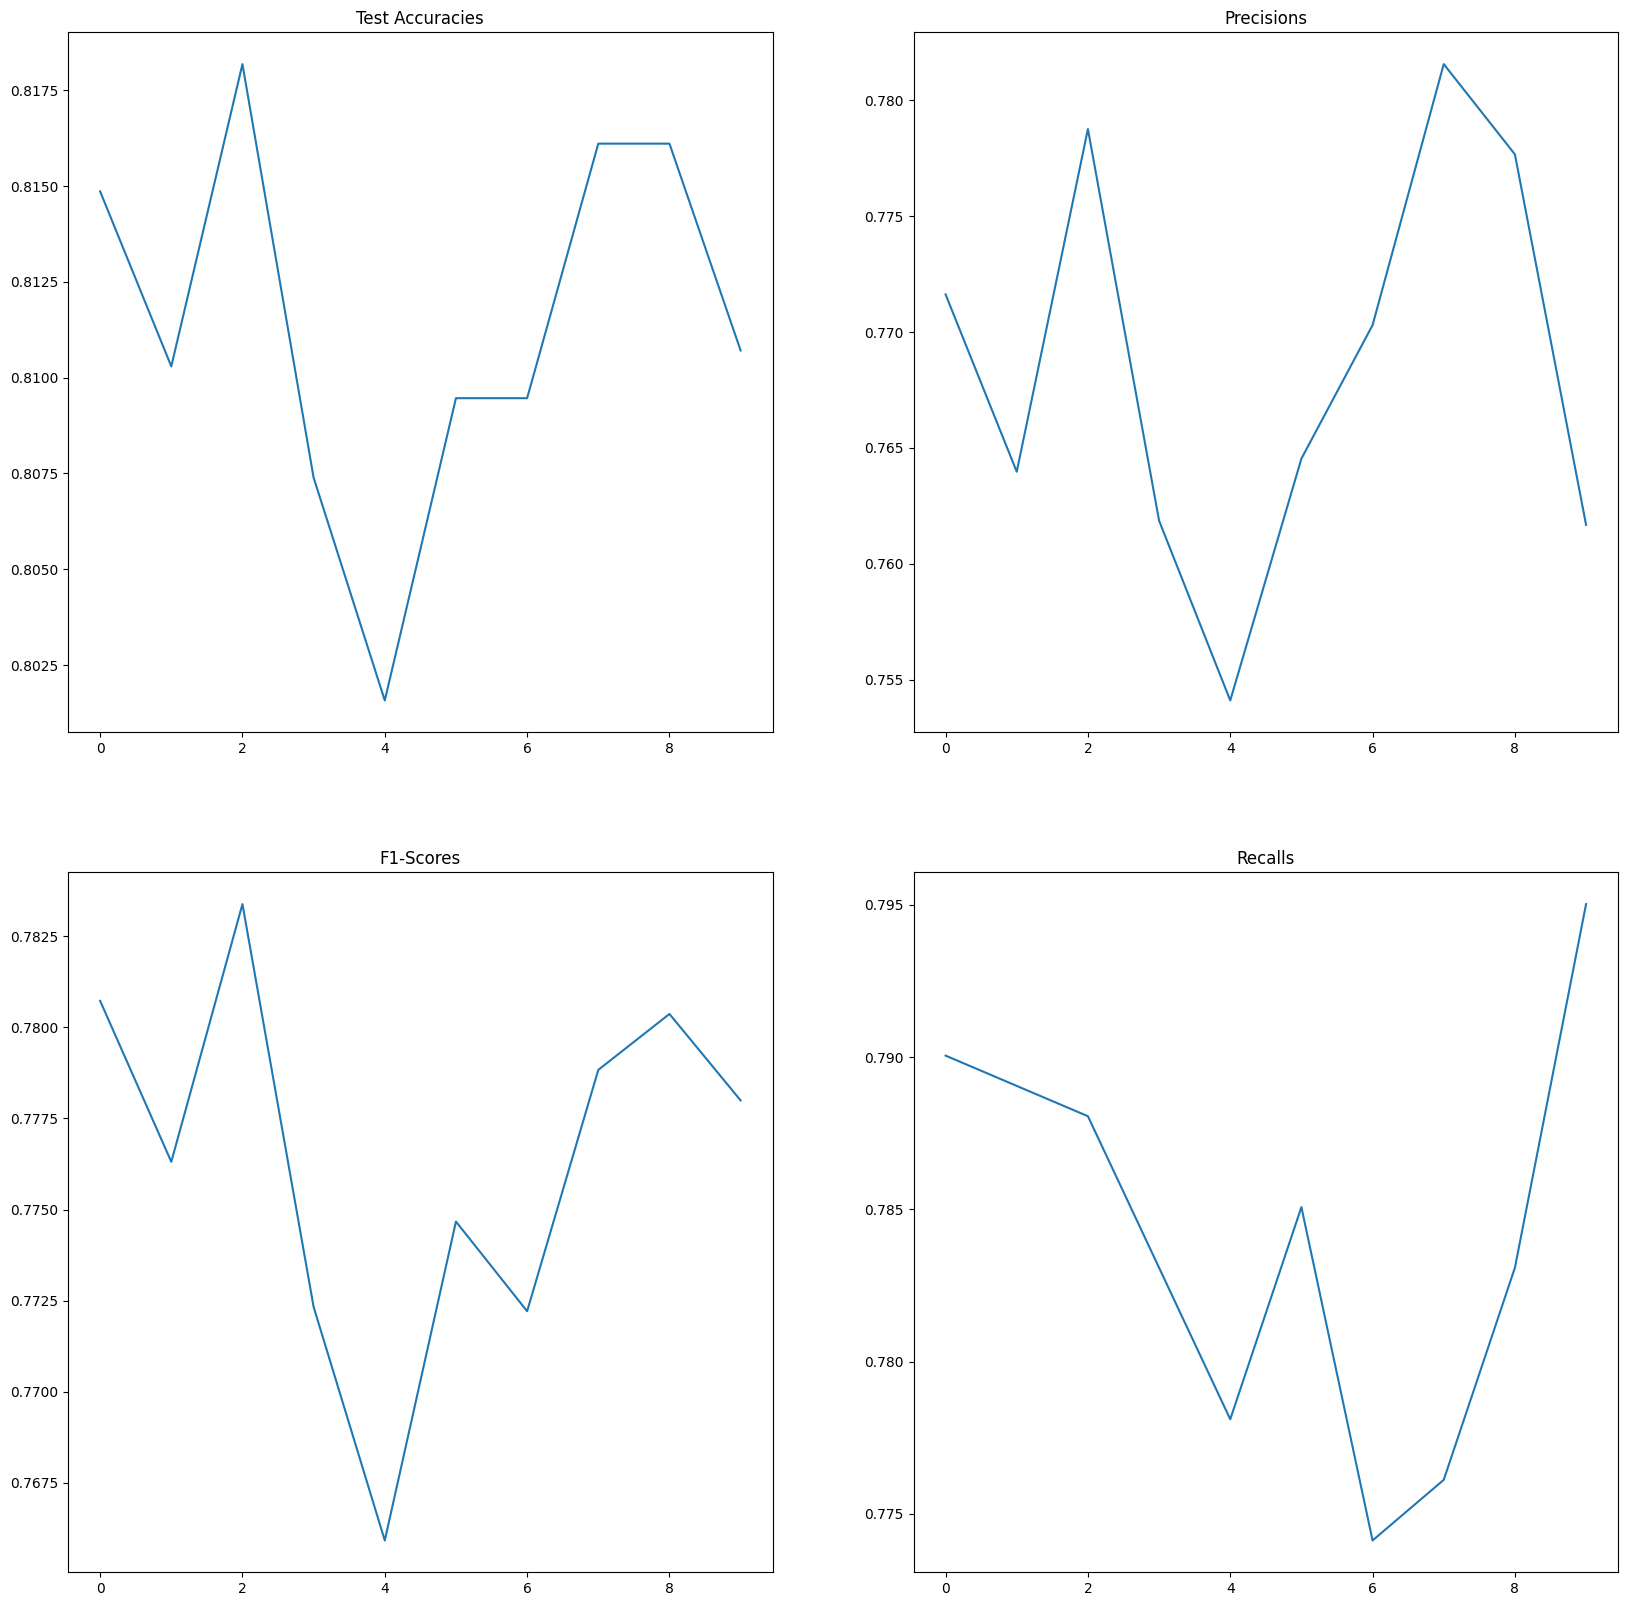

In [93]:
runs = np.arange(10)
precisions = []
accuracies = []
recalls = []
f1scores = []

for _ in range(10):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(train_sequences, train_labels, batch_size=32, epochs=5,
                        validation_data=(test_sequences, test_labels),
                        callbacks=[rlrp] ,verbose=0)
    y_pred = model.predict(test_sequences)

# Convert probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    precision = precision_score(test_labels, y_pred_binary)
    recall = recall_score(test_labels, y_pred_binary)
    f1 = f1_score(test_labels, y_pred_binary)
    accuracy = accuracy_score(test_labels, y_pred_binary)

    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1)
    accuracies.append(accuracy)

plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(runs,accuracies)
plt.title('Test Accuracies')

plt.subplot(2,2,2)
plt.plot(runs,precisions)
plt.title("Precisions")

plt.subplot(2,2,3)
plt.plot(runs,f1scores)
plt.title('F1-Scores')

plt.subplot(2,2,4)
plt.plot(runs,recalls)
plt.title('Recalls')

plt.show()



In [94]:
print("Mean Precision: "+  str(np.mean(precisions))+ " +- " + str(np.std(precisions)))
print("Mean Accuracy: "+ str(np.mean(accuracies)) + " +- " + str(np.std(accuracies)))
print("Mean Recall: "+ str(np.mean(recalls))+ " +- " + str(np.std(recall)))
print("Mean F1 Scores: "+ str(np.mean(f1scores)) + " +- " + str(np.std(f1scores)))

Mean Precision: 0.7686051005295698 +- 0.008409315399838423
Mean Accuracy: 0.8114155251141553 +- 0.004733164288737286
Mean Recall: 0.784179104477612 +- 0.0
Mean F1 Scores: 0.7762731205753494 +- 0.00488478090850952


### 2. RNN

In [95]:
model_rnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.SimpleRNN(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_rnn.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 60, 64)            1280000   
                                                                 
 spatial_dropout1d_2 (Spati  (None, 60, 64)            0         
 alDropout1D)                                                    


                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 60, 32)            3104      
                                                                 
 global_max_pooling1d_25 (G  (None, 32)                0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_50 (Dense)            (None, 16)                528       
                                                                 
 dropout_25 (Dropout)        (None, 16)                0         
                                                                 
 dense_51 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1283649 (4.90 MB)
Trainable params: 1283649 (4.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


76/76 [==============================] - 0s 1ms/step


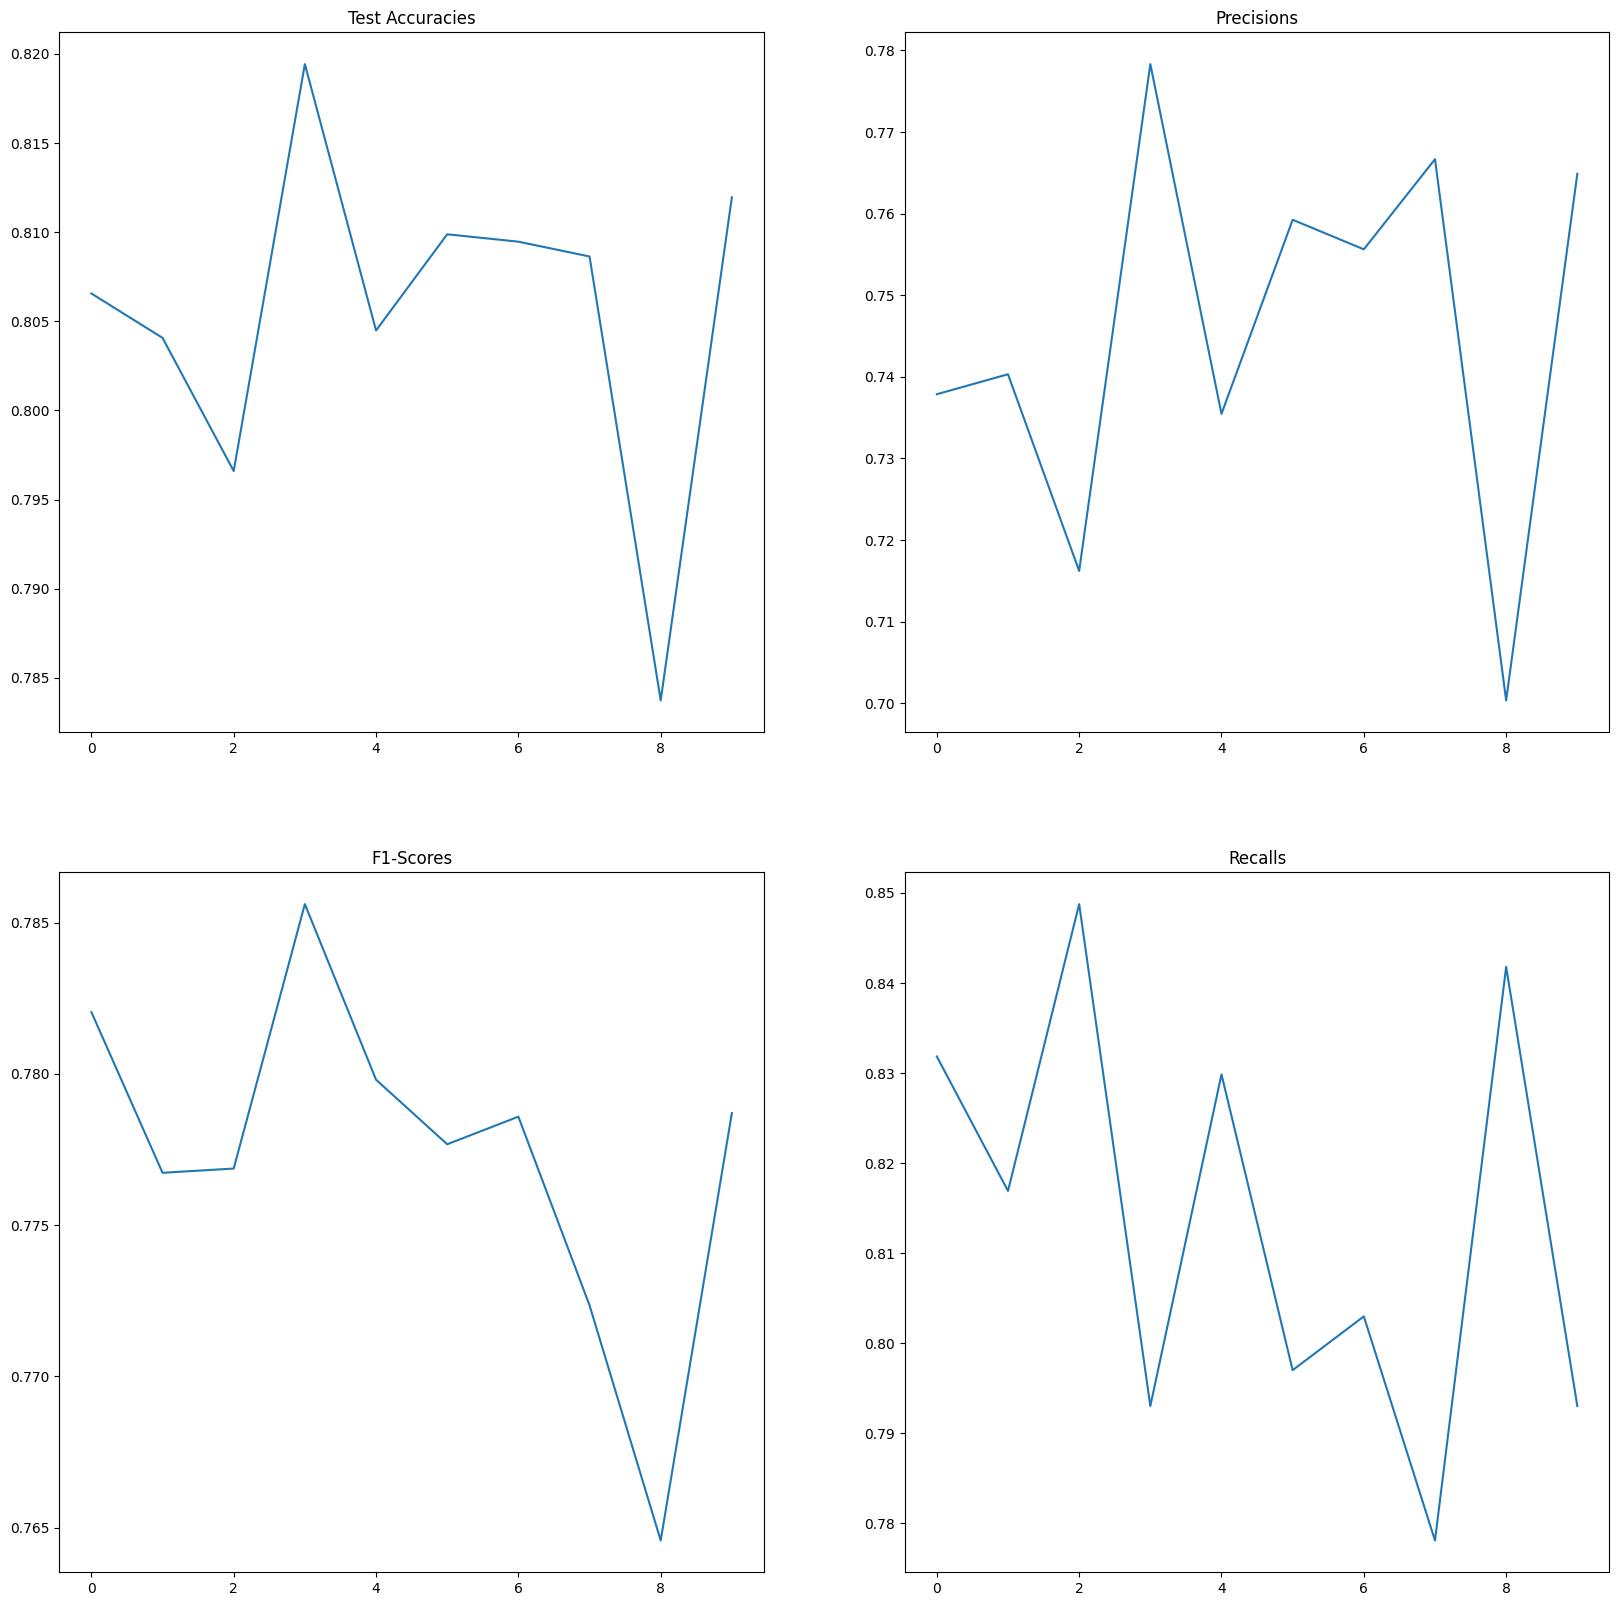

In [96]:
runs = np.arange(10)
precisions = []
accuracies = []
recalls = []
f1scores = []

for _ in range(10):
    model_rnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.SimpleRNN(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history_rnn = model_rnn.fit(train_sequences, train_labels, batch_size=32, epochs=5,
                        validation_data=(test_sequences, test_labels),
                        callbacks=[rlrp] ,verbose=0)
    y_pred = model_rnn.predict(test_sequences)

# Convert probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    precision = precision_score(test_labels, y_pred_binary)
    recall = recall_score(test_labels, y_pred_binary)
    f1 = f1_score(test_labels, y_pred_binary)
    accuracy = accuracy_score(test_labels, y_pred_binary)

    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1)
    accuracies.append(accuracy)

plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(runs,accuracies)
plt.title('Test Accuracies')

plt.subplot(2,2,2)
plt.plot(runs,precisions)
plt.title("Precisions")

plt.subplot(2,2,3)
plt.plot(runs,f1scores)
plt.title('F1-Scores')

plt.subplot(2,2,4)
plt.plot(runs,recalls)
plt.title('Recalls')

plt.show()

In [97]:
print("Mean Precision: "+  str(np.mean(precisions))+ " +- " + str(np.std(precisions)))
print("Mean Accuracy: "+ str(np.mean(accuracies)) + " +- " + str(np.std(accuracies)))
print("Mean Recall: "+ str(np.mean(recalls))+ " +- " + str(np.std(recall)))
print("Mean F1 Scores: "+ str(np.mean(f1scores)) + " +- " + str(np.std(f1scores)))

Mean Precision: 0.7454878294090597 +- 0.02297068924822753
Mean Accuracy: 0.8054794520547945 +- 0.009153528569423156
Mean Recall: 0.8133333333333332 +- 0.0
Mean F1 Scores: 0.7772916088193764 +- 0.005371614119711672


### 3. LSTM

In [98]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 60, 64)            1280000   
                                                                 
 spatial_dropout1d_13 (Spat  (None, 60, 64)            0         
 ialDropout1D)                                                   
                                                                 
 lstm (LSTM)                 (None, 60, 32)            12416     
                                                                 
 global_max_pooling1d_36 (G  (None, 32)                0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_72 (Dense)            (None, 16)                528       
                                                                 
 dropout_36 (Dropout)        (None, 16)              

76/76 [==============================] - 0s 3ms/step


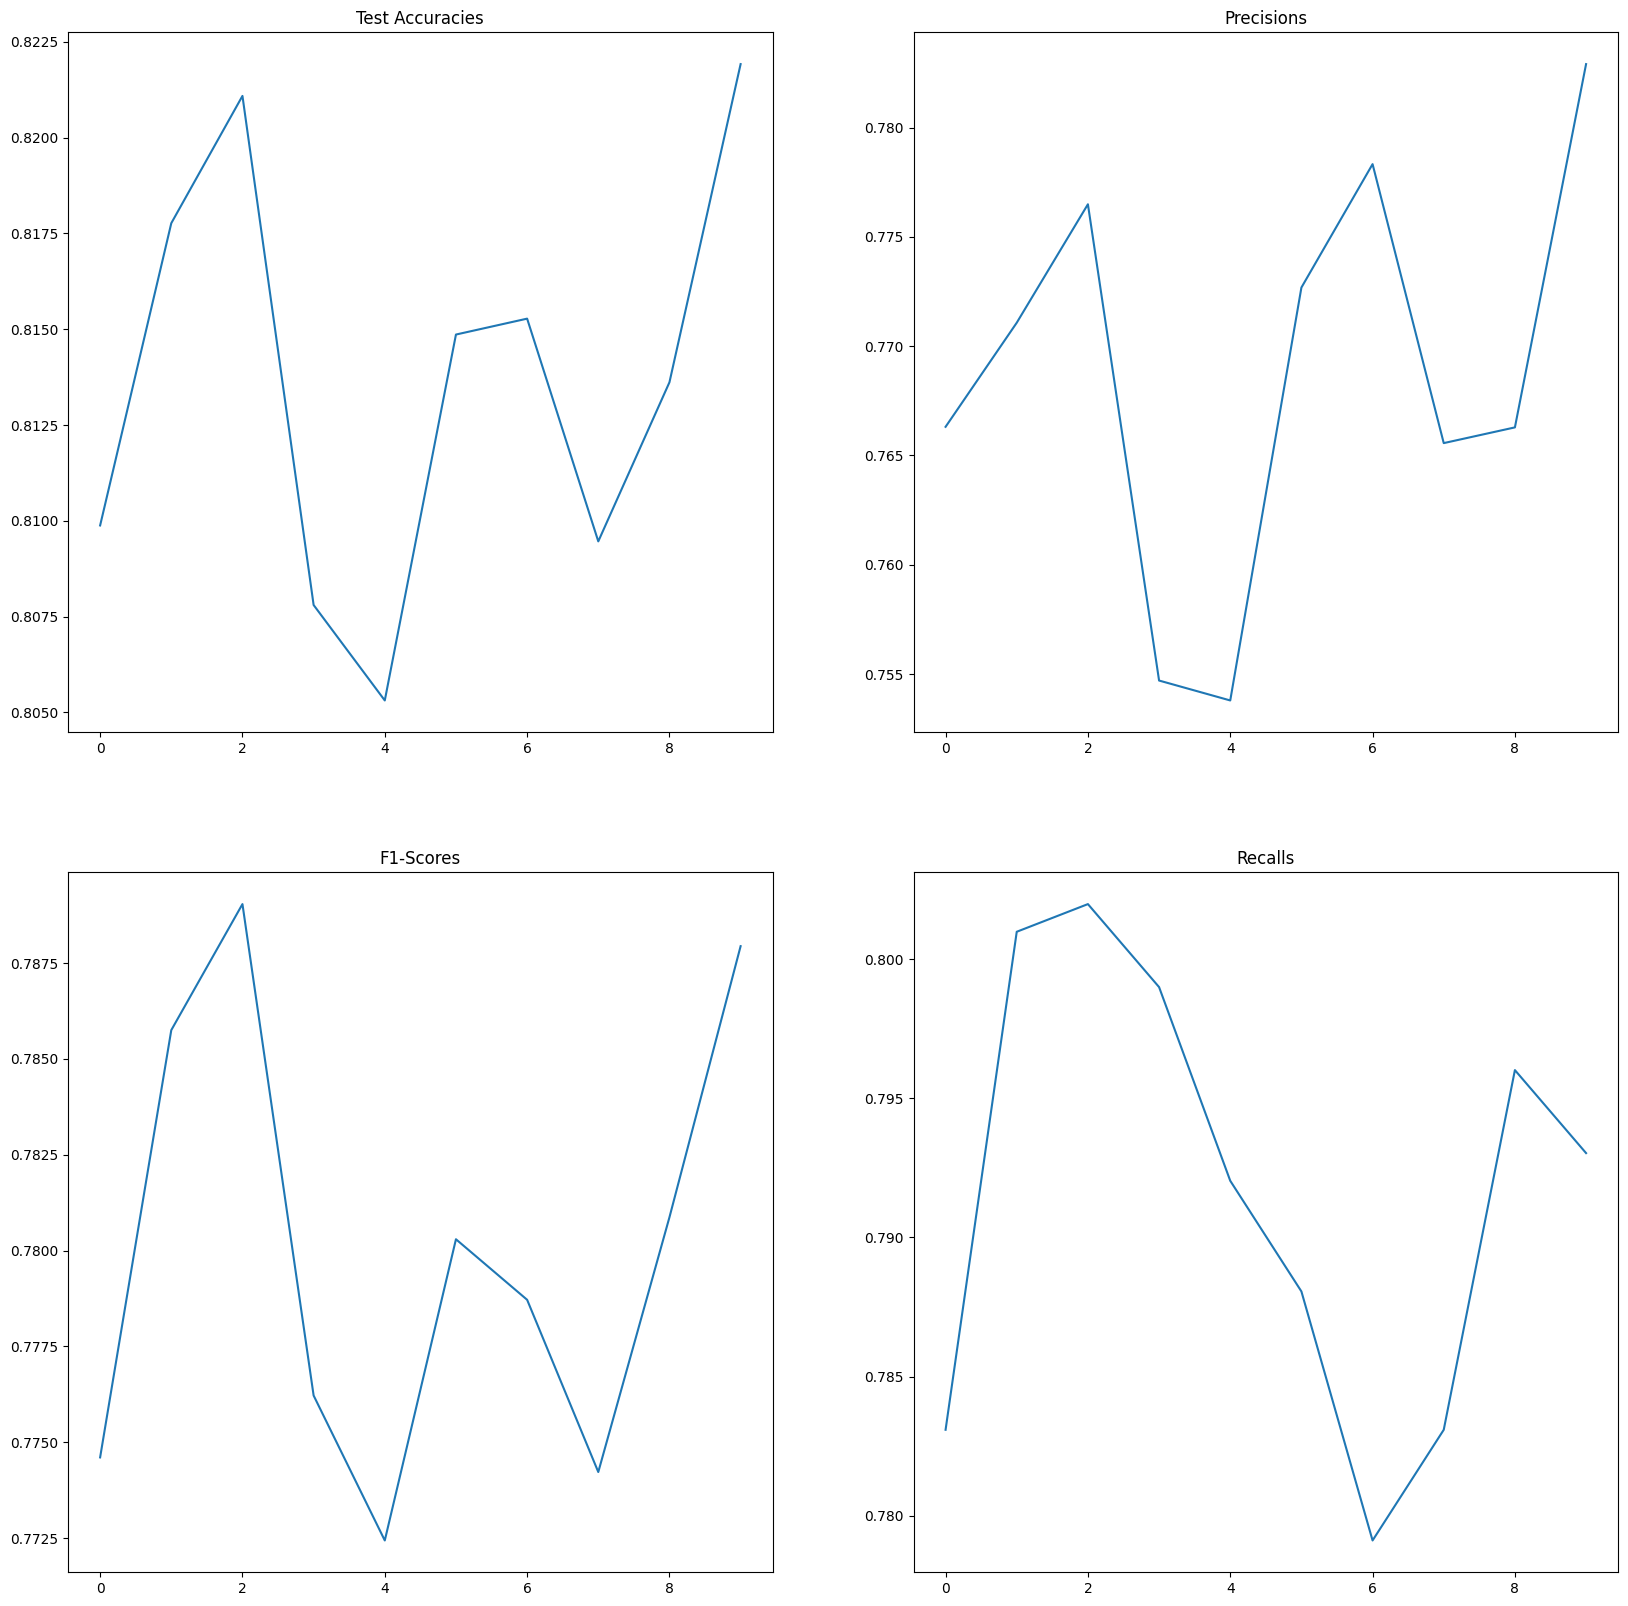

In [99]:
runs = np.arange(10)
precisions = []
accuracies = []
recalls = []
f1scores = []

for _ in range(10):
    model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history_lstm = model_lstm.fit(train_sequences, train_labels, batch_size=32, epochs=5,
                        validation_data=(test_sequences, test_labels),
                        callbacks=[rlrp] ,verbose=0)
    y_pred = model_lstm.predict(test_sequences)

# Convert probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    precision = precision_score(test_labels, y_pred_binary)
    recall = recall_score(test_labels, y_pred_binary)
    f1 = f1_score(test_labels, y_pred_binary)
    accuracy = accuracy_score(test_labels, y_pred_binary)

    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1)
    accuracies.append(accuracy)

plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(runs,accuracies)
plt.title('Test Accuracies')

plt.subplot(2,2,2)
plt.plot(runs,precisions)
plt.title("Precisions")

plt.subplot(2,2,3)
plt.plot(runs,f1scores)
plt.title('F1-Scores')

plt.subplot(2,2,4)
plt.plot(runs,recalls)
plt.title('Recalls')

plt.show()

In [100]:
print("Mean Precision: "+  str(np.mean(precisions))+ " +- " + str(np.std(precisions)))
print("Mean Accuracy: "+ str(np.mean(accuracies)) + " +- " + str(np.std(accuracies)))
print("Mean Recall: "+ str(np.mean(recalls))+ " +- " + str(np.std(recall)))
print("Mean F1 Scores: "+ str(np.mean(f1scores)) + " +- " + str(np.std(f1scores)))

Mean Precision: 0.7688131155863792 +- 0.00903589797056142
Mean Accuracy: 0.8136986301369863 +- 0.0052926118557108095
Mean Recall: 0.7916417910447762 +- 0.0
Mean F1 Scores: 0.7800097462932187 +- 0.005604257723354341


### 4. LSTM with GlobalAveragePooL

In [101]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

model_lstm_avg = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_lstm_avg.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm_avg.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_47 (Embedding)    (None, 60, 64)            1280000   
                                                                 
 spatial_dropout1d_24 (Spat  (None, 60, 64)            0         
 ialDropout1D)                                                   
                                                                 
 lstm_11 (LSTM)              (None, 60, 32)            12416     
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_94 (Dense)            (None, 16)                528       
                                                                 
 dropout_47 (Dropout)        (None, 16)              

76/76 [==============================] - 0s 3ms/step


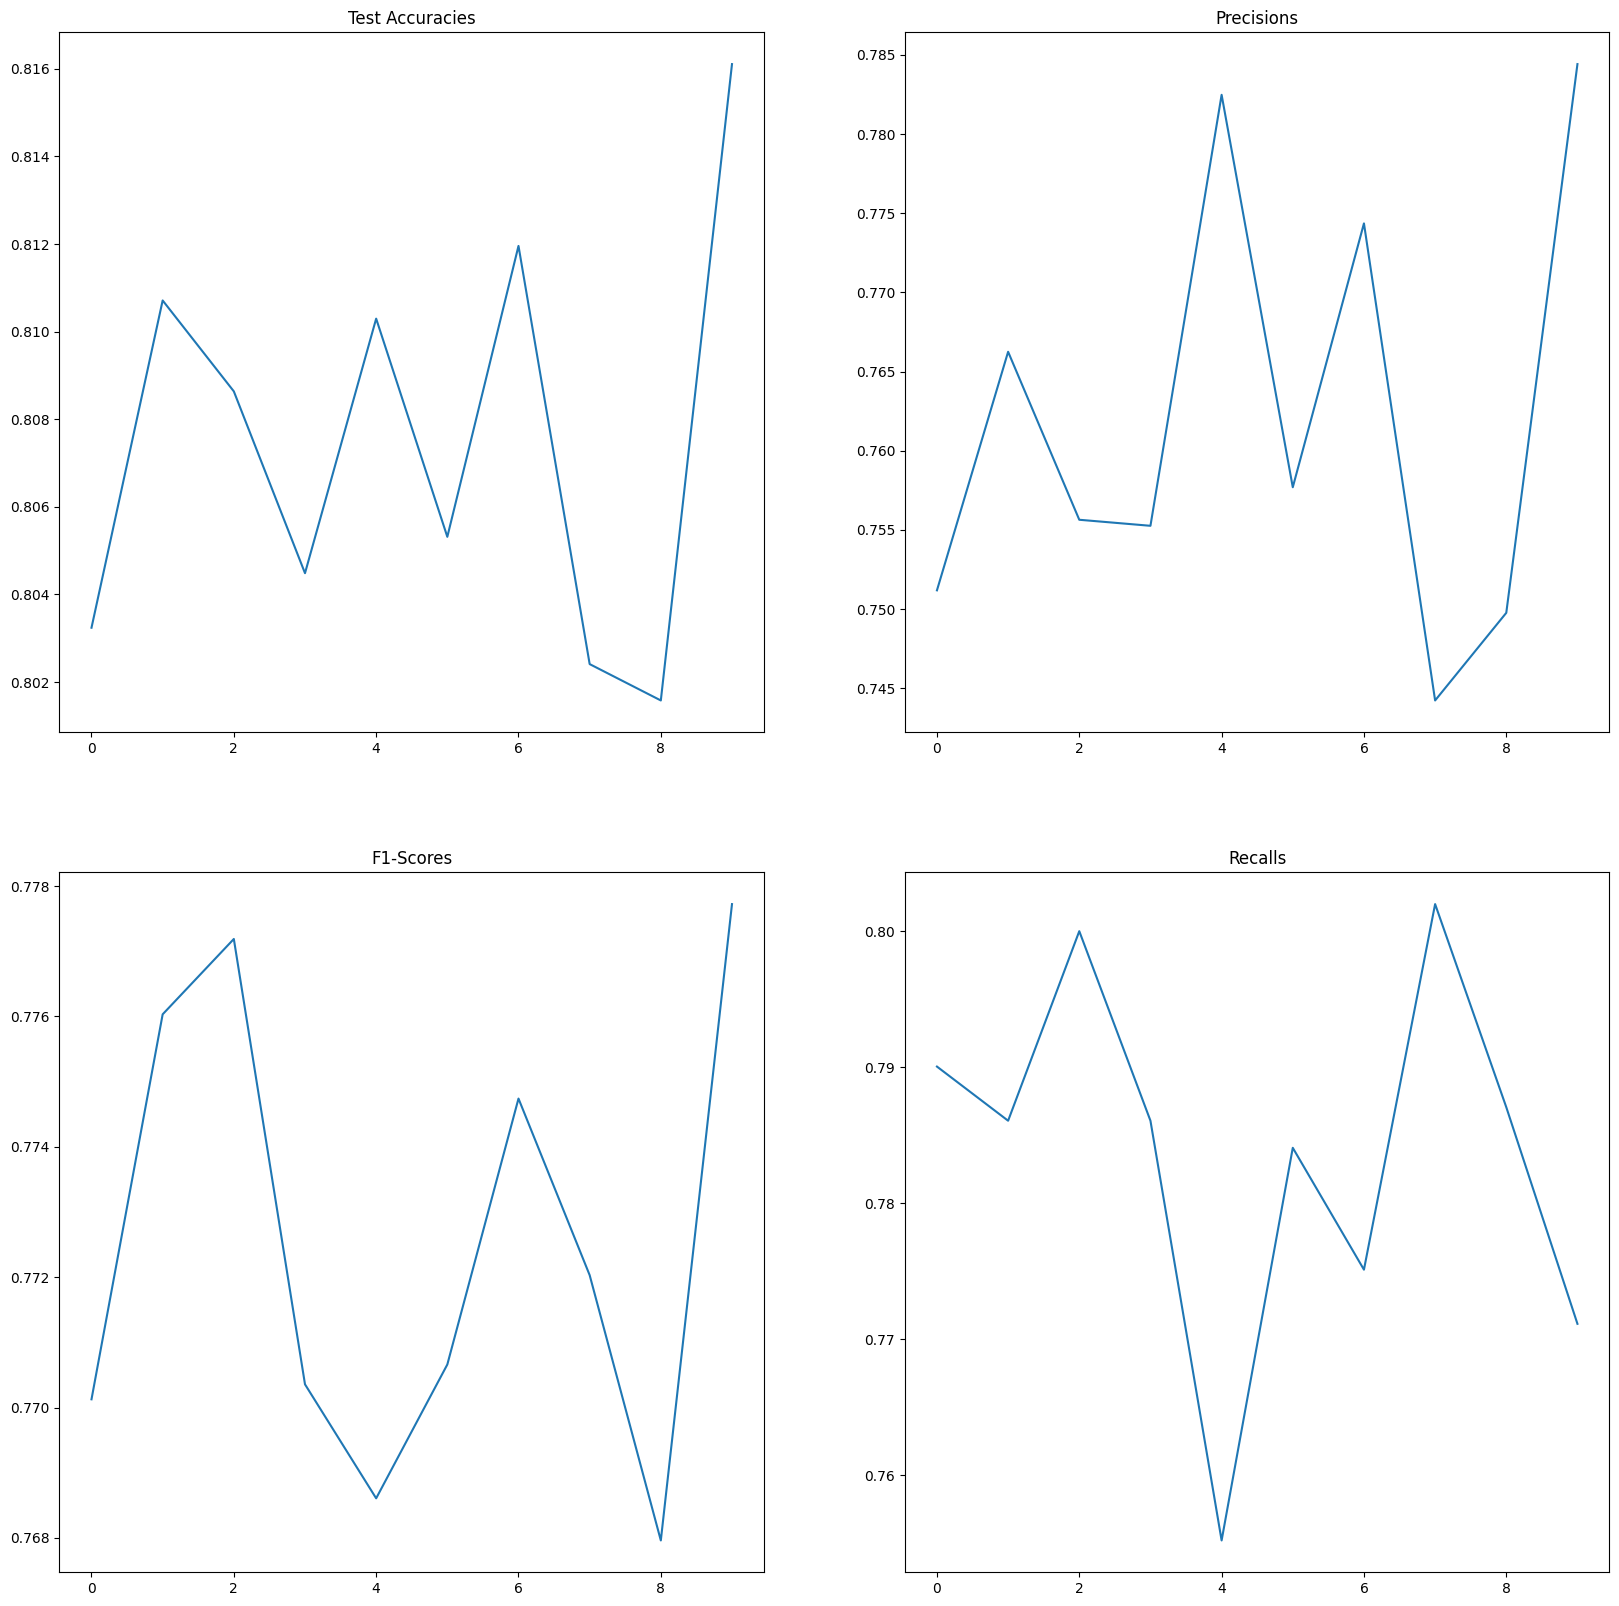

In [102]:
runs = np.arange(10)
precisions = []
accuracies = []
recalls = []
f1scores = []

for _ in range(10):
    model_lstm_avg = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    model_lstm_avg.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history_lstm_avg = model_lstm_avg.fit(train_sequences, train_labels, batch_size=32, epochs=5,
                        validation_data=(test_sequences, test_labels),
                        callbacks=[rlrp] ,verbose=0)
    y_pred = model_lstm_avg.predict(test_sequences)

# Convert probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    precision = precision_score(test_labels, y_pred_binary)
    recall = recall_score(test_labels, y_pred_binary)
    f1 = f1_score(test_labels, y_pred_binary)
    accuracy = accuracy_score(test_labels, y_pred_binary)

    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1)
    accuracies.append(accuracy)

plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(runs,accuracies)
plt.title('Test Accuracies')

plt.subplot(2,2,2)
plt.plot(runs,precisions)
plt.title("Precisions")

plt.subplot(2,2,3)
plt.plot(runs,f1scores)
plt.title('F1-Scores')

plt.subplot(2,2,4)
plt.plot(runs,recalls)
plt.title('Recalls')

plt.show()

In [103]:
print("Mean Precision: "+  str(np.mean(precisions))+ " +- " + str(np.std(precisions)))
print("Mean Accuracy: "+ str(np.mean(accuracies)) + " +- " + str(np.std(accuracies)))
print("Mean Recall: "+ str(np.mean(recalls))+ " +- " + str(np.std(recall)))
print("Mean F1 Scores: "+ str(np.mean(f1scores)) + " +- " + str(np.std(f1scores)))

Mean Precision: 0.7621251572349601 +- 0.013338164232955701
Mean Accuracy: 0.8074719800747197 +- 0.004542752684202395
Mean Recall: 0.783681592039801 +- 0.0
Mean F1 Scores: 0.7725421017153543 +- 0.0034101877450071


### 5. LSTM with only one FC Dense Layer

In [104]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

model_lstm1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_lstm1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm1.summary()

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_58 (Embedding)    (None, 60, 64)            1280000   
                                                                 
 spatial_dropout1d_35 (Spat  (None, 60, 64)            0         
 ialDropout1D)                                                   
                                                                 
 lstm_22 (LSTM)              (None, 60, 32)            12416     
                                                                 
 global_max_pooling1d_47 (G  (None, 32)                0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_116 (Dense)           (None, 1)                 33        
                                                                 
Total params: 1292449 (4.93 MB)
Trainable params: 129

In [105]:
runs = np.arange(10)
precisions = []
accuracies = []
recalls = []
f1scores = []

for _ in range(10):
    model_lstm1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    model_lstm1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history_lstm1 = model_lstm1.fit(train_sequences, train_labels, batch_size=32, epochs=5,
                        validation_data=(test_sequences, test_labels),
                        callbacks=[rlrp] ,verbose=0)
    y_pred = model_lstm1.predict(test_sequences)

# Convert probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    precision = precision_score(test_labels, y_pred_binary)
    recall = recall_score(test_labels, y_pred_binary)
    f1 = f1_score(test_labels, y_pred_binary)
    accuracy = accuracy_score(test_labels, y_pred_binary)

    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1)
    accuracies.append(accuracy)

plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(runs,accuracies)
plt.title('Test Accuracies')

plt.subplot(2,2,2)
plt.plot(runs,precisions)
plt.title("Precisions")

plt.subplot(2,2,3)
plt.plot(runs,f1scores)
plt.title('F1-Scores')

plt.subplot(2,2,4)
plt.plot(runs,recalls)
plt.title('Recalls')

plt.show()

76/76 [==============================] - 0s 3ms/step


KeyboardInterrupt: 

In [ ]:
print("Mean Precision: "+  str(np.mean(precisions))+ " +- " + str(np.std(precisions)))
print("Mean Accuracy: "+ str(np.mean(accuracies)) + " +- " + str(np.std(accuracies)))
print("Mean Recall: "+ str(np.mean(recalls))+ " +- " + str(np.std(recall)))
print("Mean F1 Scores: "+ str(np.mean(f1scores)) + " +- " + str(np.std(f1scores)))

Mean Precision: 0.8383211569942726 +- 0.00814237208506628
Mean Accuracy: 0.8344524793388428 +- 0.001916114237043142
Mean Recall: 0.8213609259908805 +- 0.0
Mean F1 Scores: 0.8296543646240971 +- 0.00234608657309763


### 6. STACKED LSTM

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

model_st_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_st_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_st_lstm.summary()

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_75 (Embedding)    (None, 60, 64)            1280000   
                                                                 
 spatial_dropout1d_61 (Spat  (None, 60, 64)            0         
 ialDropout1D)                                                   
                                                                 
 lstm_40 (LSTM)              (None, 60, 32)            12416     
                                                                 
 lstm_41 (LSTM)              (None, 60, 32)            8320      
                                                                 
 global_max_pooling1d_64 (G  (None, 32)                0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_139 (Dense)           (None, 16)              

182/182 [==============================] - 1s 5ms/step


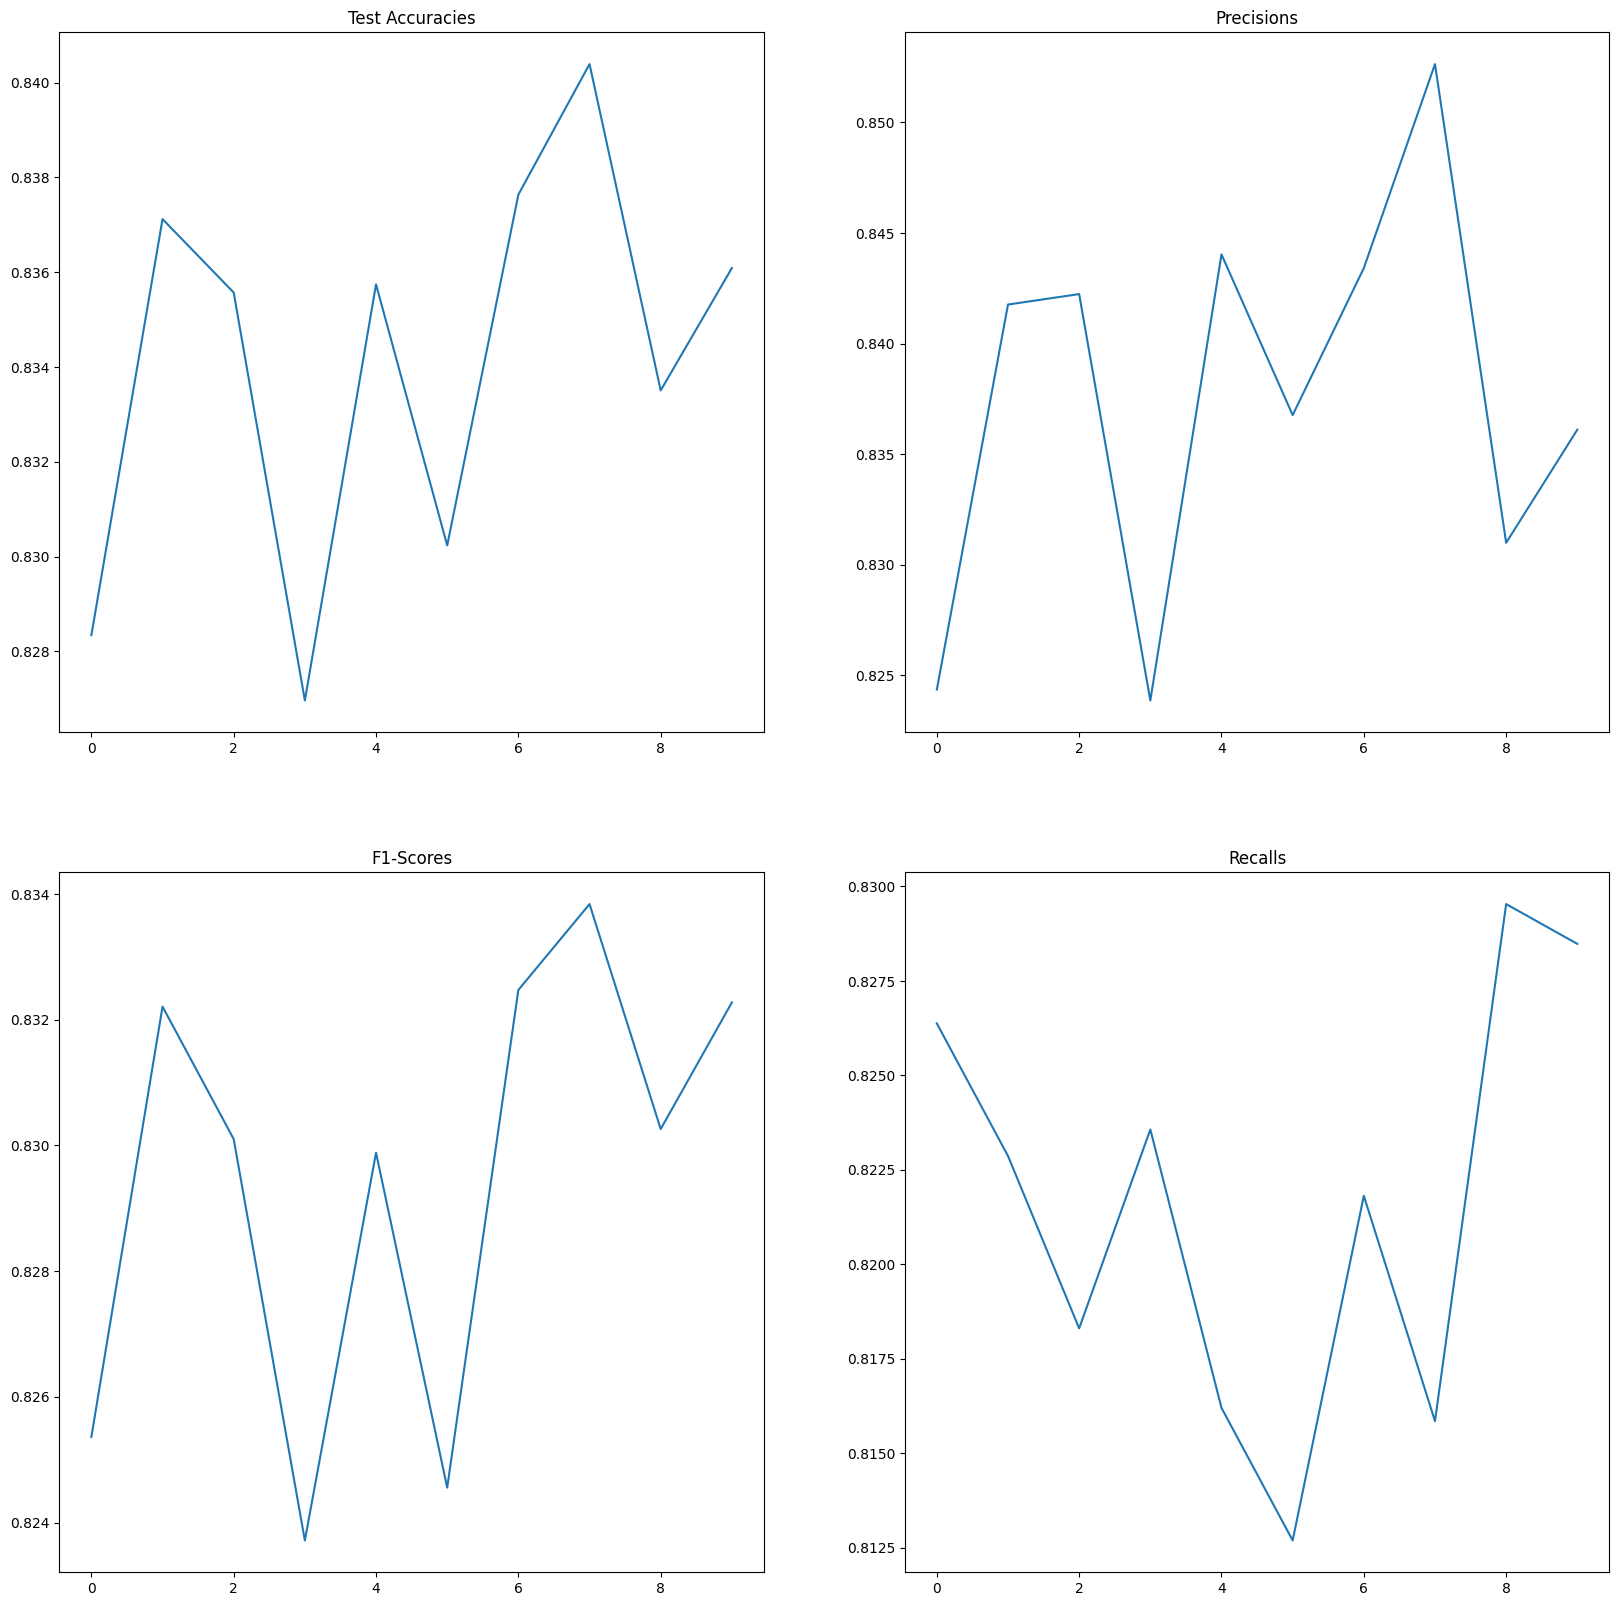

In [ ]:
runs = np.arange(10)
precisions = []
accuracies = []
recalls = []
f1scores = []

for _ in range(10):
    model_st_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    model_st_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history_st_lstm = model_st_lstm.fit(train_sequences, train_labels, batch_size=32, epochs=5,
                        validation_data=(test_sequences, test_labels),
                        callbacks=[rlrp] ,verbose=0)
    y_pred = model_st_lstm.predict(test_sequences)

# Convert probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    precision = precision_score(test_labels, y_pred_binary)
    recall = recall_score(test_labels, y_pred_binary)
    f1 = f1_score(test_labels, y_pred_binary)
    accuracy = accuracy_score(test_labels, y_pred_binary)

    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1)
    accuracies.append(accuracy)

plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(runs,accuracies)
plt.title('Test Accuracies')

plt.subplot(2,2,2)
plt.plot(runs,precisions)
plt.title("Precisions")

plt.subplot(2,2,3)
plt.plot(runs,f1scores)
plt.title('F1-Scores')

plt.subplot(2,2,4)
plt.plot(runs,recalls)
plt.title('Recalls')

plt.show()

In [ ]:
print("Mean Precision: "+  str(np.mean(precisions))+ " +- " + str(np.std(precisions)))
print("Mean Accuracy: "+ str(np.mean(accuracies)) + " +- " + str(np.std(accuracies)))
print("Mean Recall: "+ str(np.mean(recalls))+ " +- " + str(np.std(recall)))
print("Mean F1 Scores: "+ str(np.mean(f1scores)) + " +- " + str(np.std(f1scores)))

Mean Precision: 0.8376162376180659 +- 0.008666684283957449
Mean Accuracy: 0.8341597796143251 +- 0.004116274286232537
Mean Recall: 0.821571378463697 +- 0.0
Mean F1 Scores: 0.8294684712237494 +- 0.003447520698509612


### 7. GRU

In [ ]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gru.summary()

Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_86 (Embedding)    (None, 60, 64)            1280000   
                                                                 
 gru (GRU)                   (None, 60, 32)            9408      
                                                                 
 global_max_pooling1d_75 (G  (None, 32)                0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_161 (Dense)           (None, 16)                528       
                                                                 
 dropout_75 (Dropout)        (None, 16)                0         
                                                                 
 dense_162 (Dense)           (None, 1)                 17        
                                                     

182/182 [==============================] - 1s 2ms/step


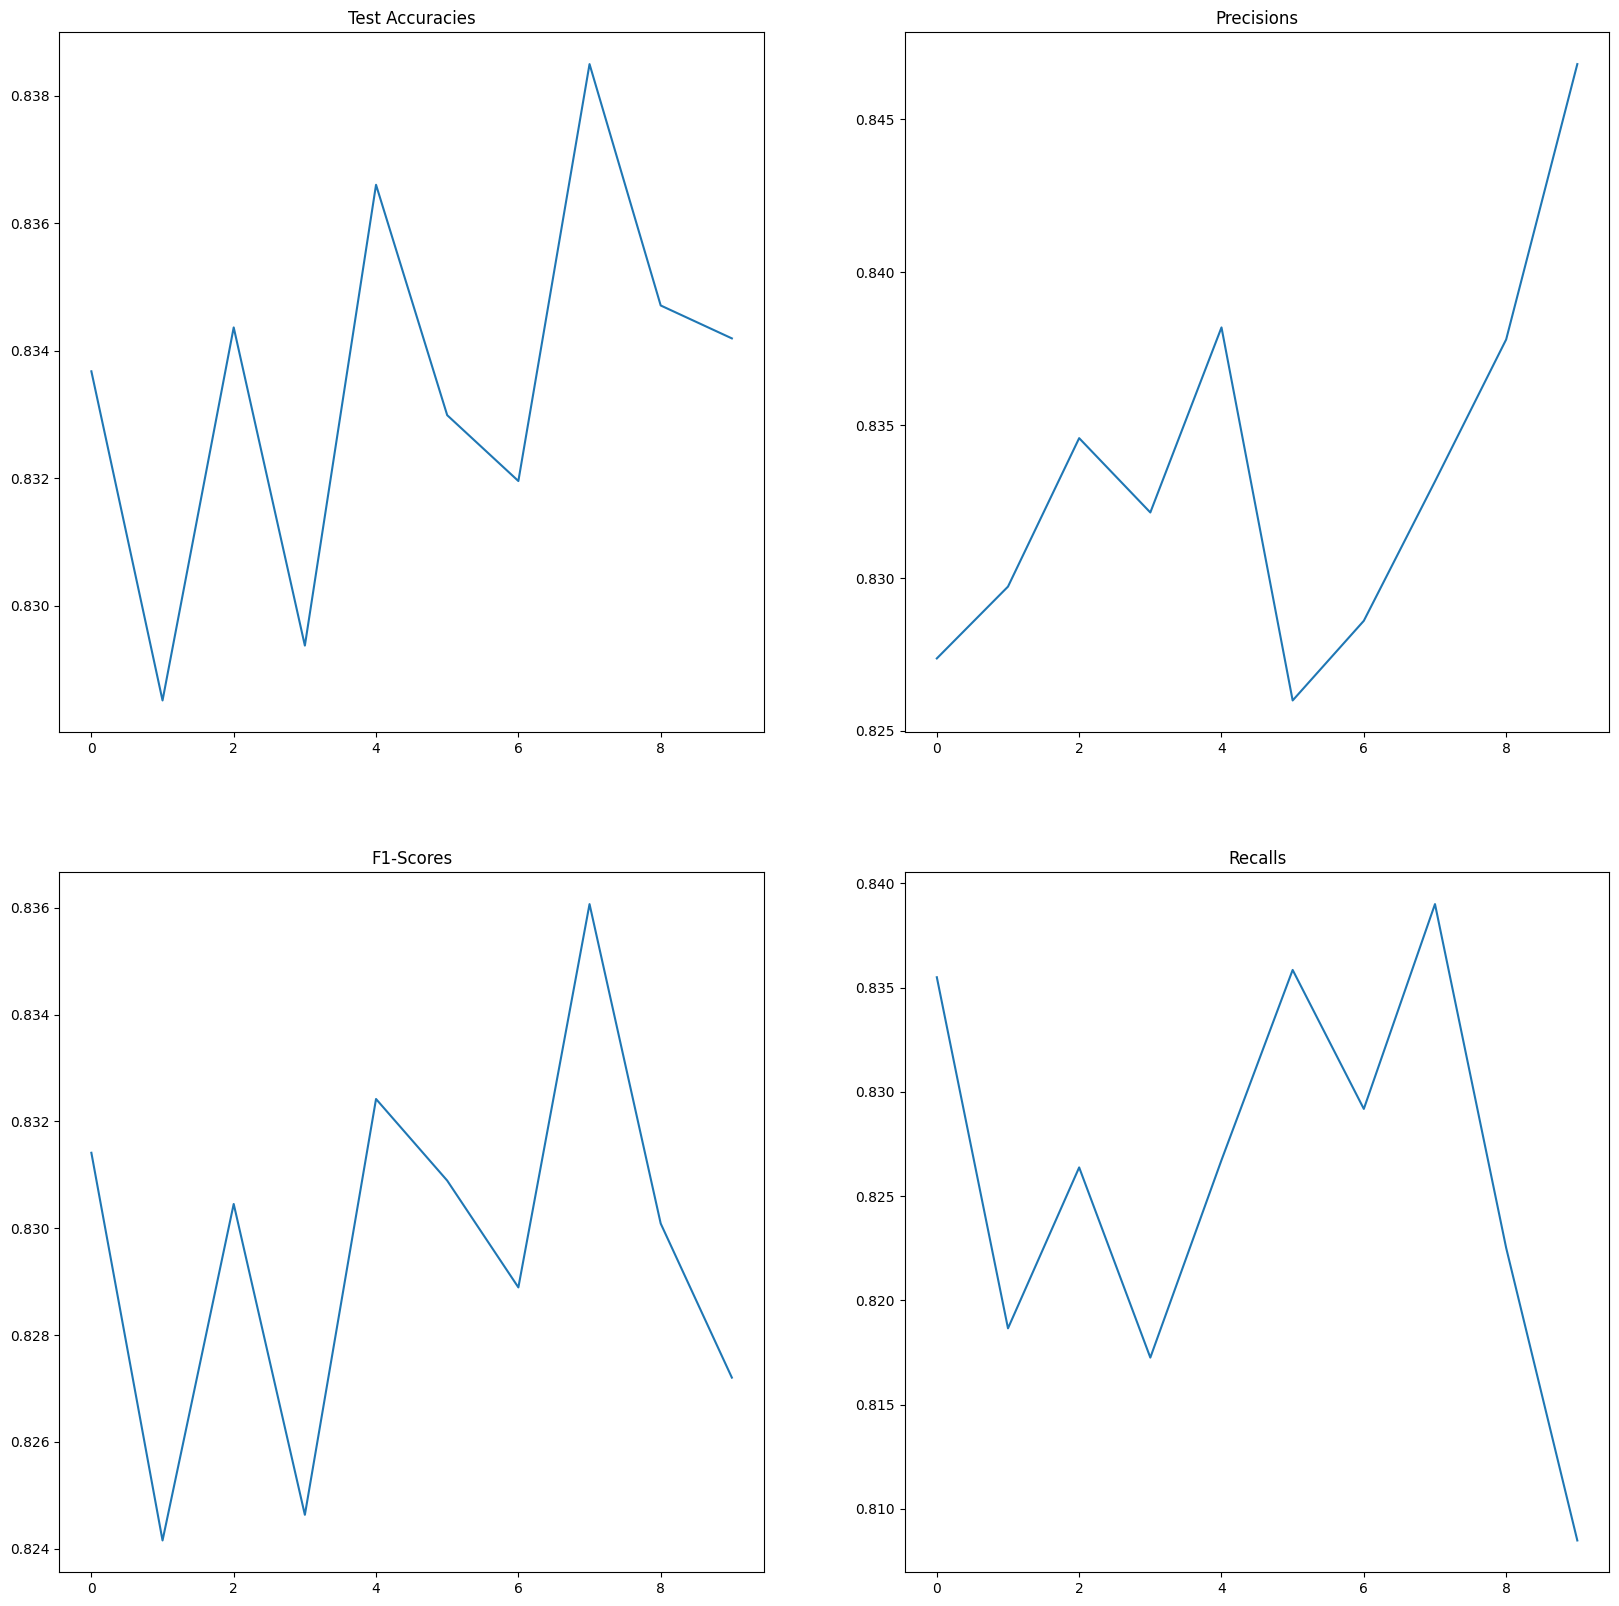

In [ ]:
runs = np.arange(10)
precisions = []
accuracies = []
recalls = []
f1scores = []

for _ in range(10):
    model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history_gru = model_gru.fit(train_sequences, train_labels, batch_size=32, epochs=5,
                        validation_data=(test_sequences, test_labels),
                        callbacks=[rlrp] ,verbose=0)
    y_pred = model_gru.predict(test_sequences)

# Convert probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    precision = precision_score(test_labels, y_pred_binary)
    recall = recall_score(test_labels, y_pred_binary)
    f1 = f1_score(test_labels, y_pred_binary)
    accuracy = accuracy_score(test_labels, y_pred_binary)

    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1)
    accuracies.append(accuracy)

plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(runs,accuracies)
plt.title('Test Accuracies')

plt.subplot(2,2,2)
plt.plot(runs,precisions)
plt.title("Precisions")

plt.subplot(2,2,3)
plt.plot(runs,f1scores)
plt.title('F1-Scores')

plt.subplot(2,2,4)
plt.plot(runs,recalls)
plt.title('Recalls')

plt.show()

In [ ]:
print("Mean Precision: "+  str(np.mean(precisions))+ " +- " + str(np.std(precisions)))
print("Mean Accuracy: "+ str(np.mean(accuracies)) + " +- " + str(np.std(accuracies)))
print("Mean Recall: "+ str(np.mean(recalls))+ " +- " + str(np.std(recall)))
print("Mean F1 Scores: "+ str(np.mean(f1scores)) + " +- " + str(np.std(f1scores)))

Mean Precision: 0.8334359457366253 +- 0.005939139031146951
Mean Accuracy: 0.8334882920110193 +- 0.0028619100221615314
Mean Recall: 0.8259558049807085 +- 0.0
Mean F1 Scores: 0.8296221644147028 +- 0.0034111083448861526


### 8. BiLSTM

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

model_bidir = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_bidir.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bidir.summary()

Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_97 (Embedding)    (None, 60, 64)            1280000   
                                                                 
 bidirectional (Bidirection  (None, 60, 64)            24832     
 al)                                                             
                                                                 
 global_max_pooling1d_86 (G  (None, 64)                0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_183 (Dense)           (None, 16)                1040      
                                                                 
 dropout_86 (Dropout)        (None, 16)                0         
                                                                 
 dense_184 (Dense)           (None, 1)               

182/182 [==============================] - 1s 3ms/step


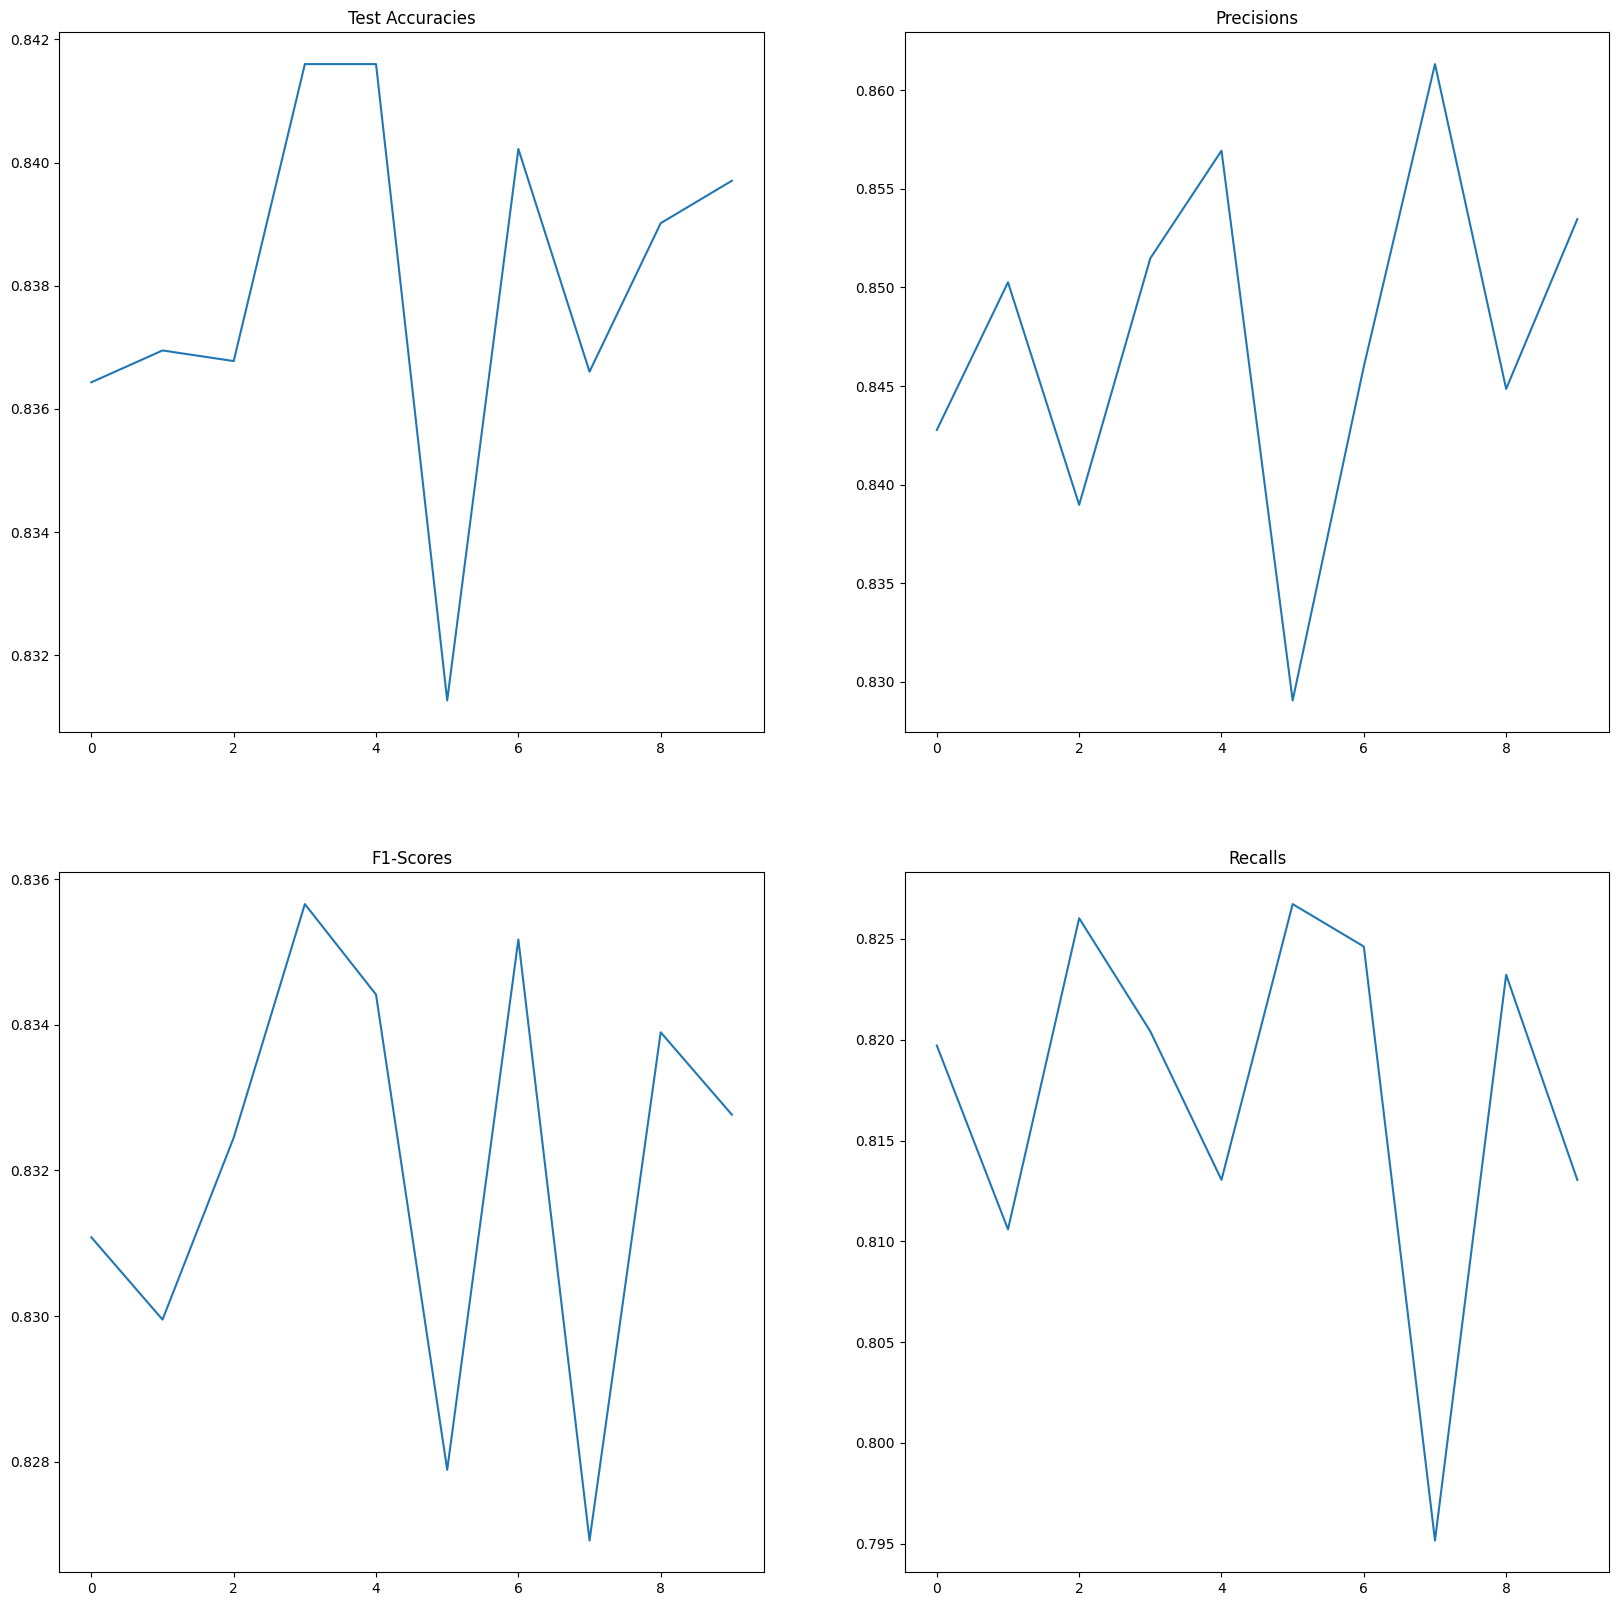

In [ ]:
runs = np.arange(10)
precisions = []
accuracies = []
recalls = []
f1scores = []

for _ in range(10):
    model_bidir = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    model_bidir.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history_bidir = model_bidir.fit(train_sequences, train_labels, batch_size=32, epochs=5,
                        validation_data=(test_sequences, test_labels),
                        callbacks=[rlrp] ,verbose=0)
    y_pred = model_bidir.predict(test_sequences)

# Convert probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    precision = precision_score(test_labels, y_pred_binary)
    recall = recall_score(test_labels, y_pred_binary)
    f1 = f1_score(test_labels, y_pred_binary)
    accuracy = accuracy_score(test_labels, y_pred_binary)

    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1)
    accuracies.append(accuracy)

plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(runs,accuracies)
plt.title('Test Accuracies')

plt.subplot(2,2,2)
plt.plot(runs,precisions)
plt.title("Precisions")

plt.subplot(2,2,3)
plt.plot(runs,f1scores)
plt.title('F1-Scores')

plt.subplot(2,2,4)
plt.plot(runs,recalls)
plt.title('Recalls')

plt.show()

In [ ]:
print("Mean Precision: "+  str(np.mean(precisions))+ " +- " + str(np.std(precisions)))
print("Mean Accuracy: "+ str(np.mean(accuracies)) + " +- " + str(np.std(accuracies)))
print("Mean Recall: "+ str(np.mean(recalls))+ " +- " + str(np.std(recall)))
print("Mean F1 Scores: "+ str(np.mean(f1scores)) + " +- " + str(np.std(f1scores)))

Mean Precision: 0.847508419736837 +- 0.00885193802102293
Mean Accuracy: 0.8380165289256197 +- 0.0029510034828689434
Mean Recall: 0.8172571027709574 +- 0.0
Mean F1 Scores: 0.832018878129577 +- 0.002852319161136243


### 9. BERT uncased Transformer

In [96]:
# Load model directly
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [97]:
import datasets

In [98]:
dataset = datasets.load_dataset('json',data_files={"train": "hinditrain.json","test": "hinditest.json"})

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 426.25it/s]
Generating train split: 92 examples [00:00, 2636.54 examples/s]
Generating test split: 16 examples [00:00, 3594.86 examples/s]


In [99]:
train_dataset = dataset['train']
train_data = dict(tokenizer(train_dataset['text'],return_tensors='np',padding=True))
train_labels = np.array(train_dataset['value'])


In [100]:
test_dataset = dataset['test']
test_data = dict(tokenizer(test_dataset['text'],return_tensors='np',padding=True))
test_labels = np.array(test_dataset['value'])

In [104]:
from tensorflow.keras.optimizers.legacy import Adam
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model.compile(optimizer=Adam(3e-5),metrics= ['accuracy'])
model.fit(train_data,train_labels,batch_size=8,validation_data=(test_data,test_labels),epochs=10,callbacks=[rlrp])

Epoch 1/10
12/12 [==============================] - 69s 5s/step - loss: 0.6807 - accuracy: 0.5761 - val_loss: 0.7106 - val_accuracy: 0.5000 - lr: 3.0000e-05
Epoch 2/10
12/12 [==============================] - 50s 4s/step - loss: 0.6646 - accuracy: 0.6196 - val_loss: 0.7041 - val_accuracy: 0.5000 - lr: 3.0000e-05
Epoch 3/10
12/12 [==============================] - 44s 4s/step - loss: 0.6477 - accuracy: 0.6196 - val_loss: 0.7065 - val_accuracy: 0.5000 - lr: 3.0000e-05
Epoch 4/10
12/12 [==============================] - 43s 4s/step - loss: 0.6697 - accuracy: 0.5652 - val_loss: 0.7092 - val_accuracy: 0.5000 - lr: 3.0000e-05
Epoch 5/10
12/12 [==============================] - 38s 3s/step - loss: 0.6694 - accuracy: 0.5435 - val_loss: 0.7086 - val_accuracy: 0.5000 - lr: 3.0000e-06
Epoch 6/10
12/12 [==============================] - 46s 4s/step - loss: 0.7057 - accuracy: 0.5652 - val_loss: 0.7084 - val_accuracy: 0.5000 - lr: 3.0000e-06
Epoch 7/10
12/12 [==============================] - 40s 3s

### 10. Transformer

In [173]:
from tensorflow import keras
from tensorflow.keras import layers

In [174]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [175]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [176]:
embed_dim = 64  # Embedding size for each token
vocab_size = 20000
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
maxlen = 60
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)


76/76 [==============================] - 1s 5ms/step


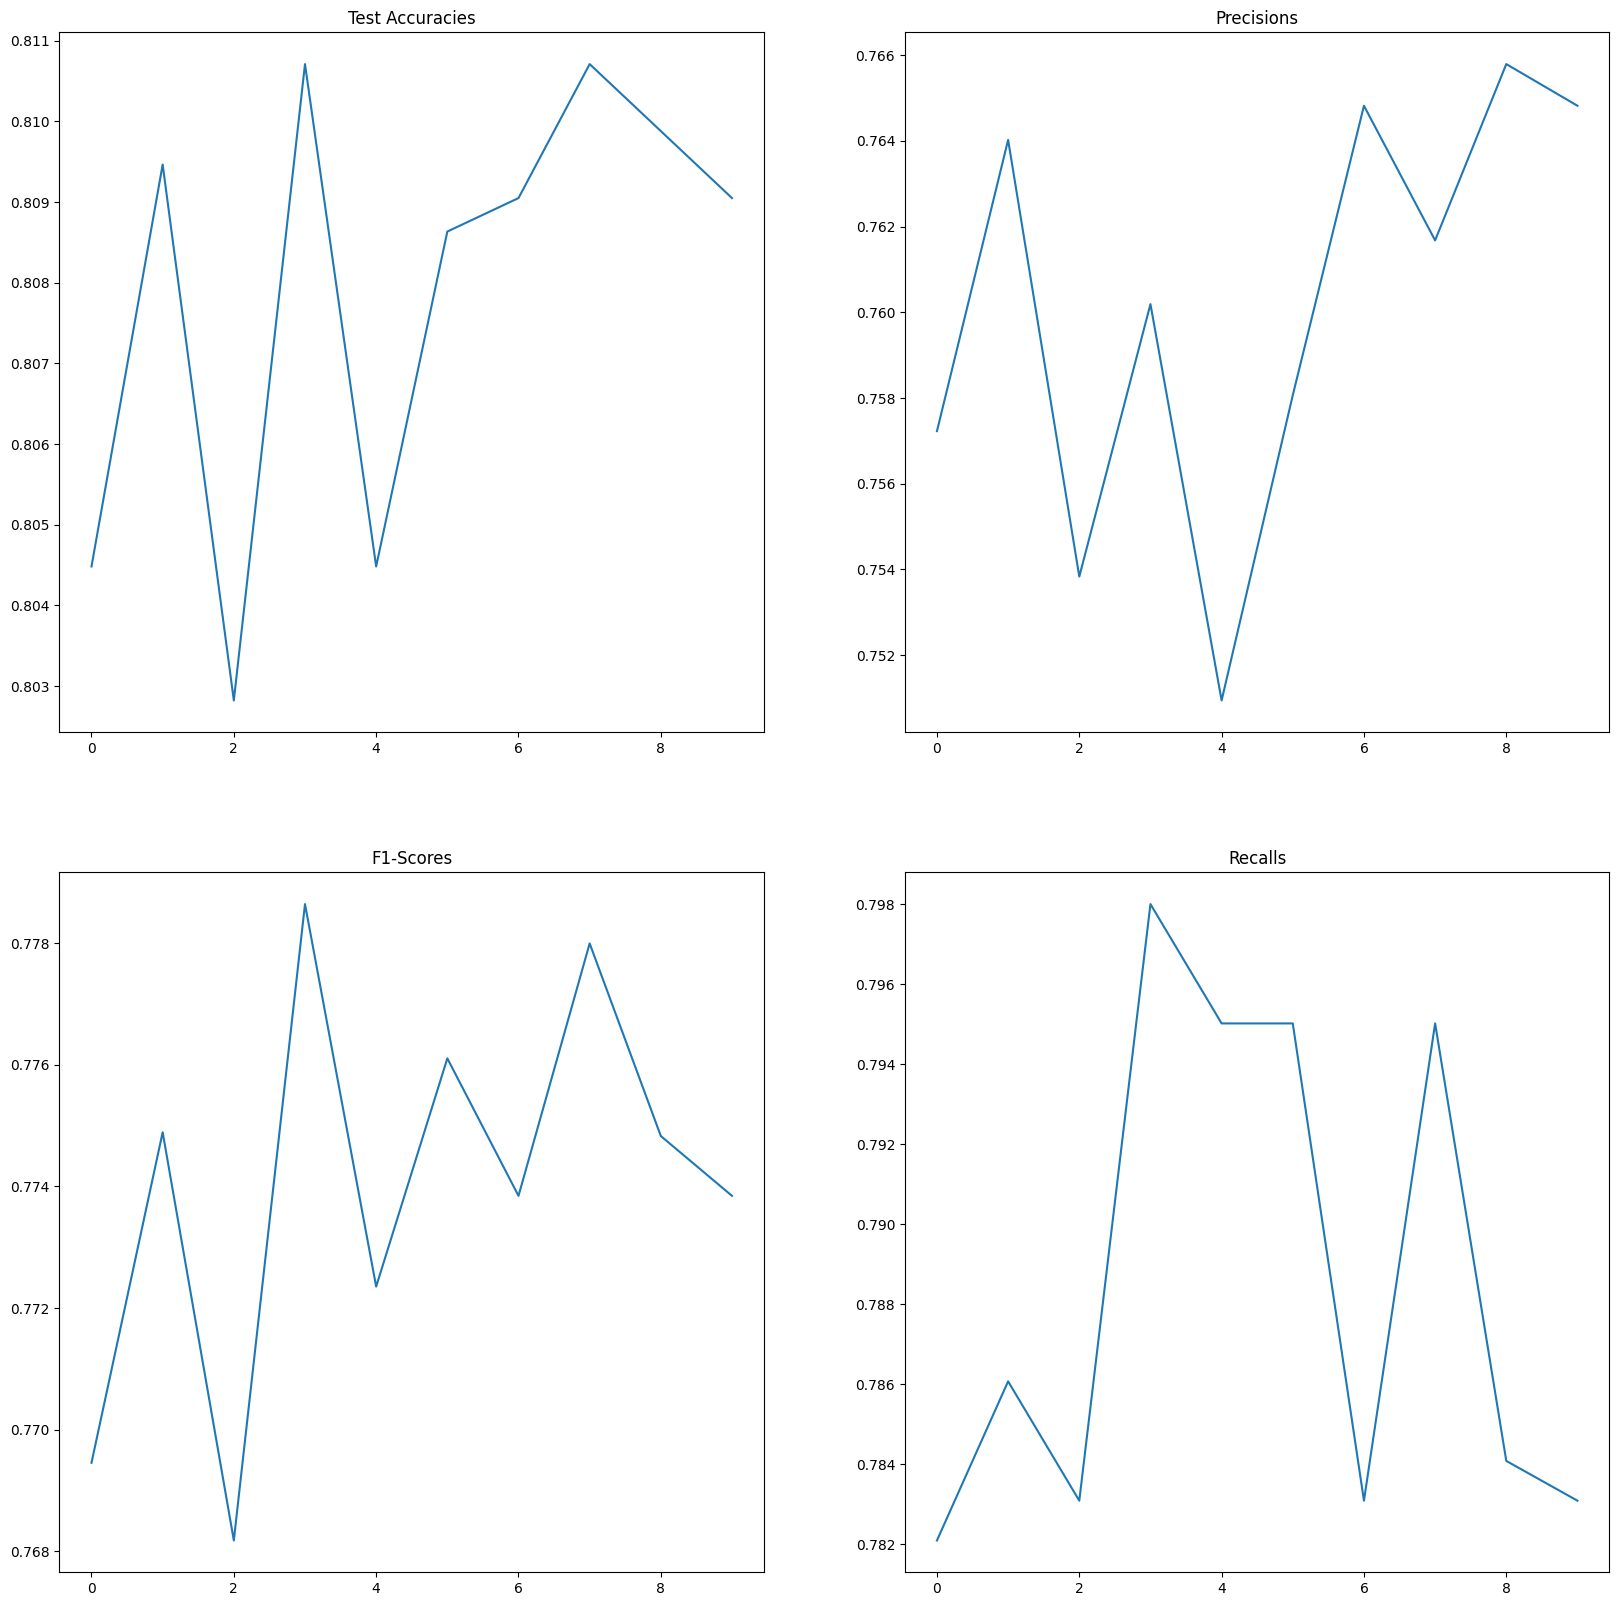

In [178]:
runs = np.arange(10)
precisions = []
accuracies = []
recalls = []
f1scores = []

for _ in range(10):
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)


    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(train_sequences, train_labels, batch_size=32, epochs=5,
                        validation_data=(test_sequences, test_labels),
                        callbacks=[rlrp] ,verbose=0)
    y_pred = model.predict(test_sequences)

# Convert probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    precision = precision_score(test_labels, y_pred_binary)
    recall = recall_score(test_labels, y_pred_binary)
    f1 = f1_score(test_labels, y_pred_binary)
    accuracy = accuracy_score(test_labels, y_pred_binary)

    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1)
    accuracies.append(accuracy)

plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(runs,accuracies)
plt.title('Test Accuracies')

plt.subplot(2,2,2)
plt.plot(runs,precisions)
plt.title("Precisions")

plt.subplot(2,2,3)
plt.plot(runs,f1scores)
plt.title('F1-Scores')

plt.subplot(2,2,4)
plt.plot(runs,recalls)
plt.title('Recalls')

plt.show()

In [179]:
print("Mean Precision: "+  str(np.mean(precisions))+ " +- " + str(np.std(precisions)))
print("Mean Accuracy: "+ str(np.mean(accuracies)) + " +- " + str(np.std(accuracies)))
print("Mean Recall: "+ str(np.mean(recalls))+ " +- " + str(np.std(recall)))
print("Mean F1 Scores: "+ str(np.mean(f1scores)) + " +- " + str(np.std(f1scores)))

Mean Precision: 0.7601384248262704 +- 0.004800459557861517
Mean Accuracy: 0.807928601079286 +- 0.0027286971240423107
Mean Recall: 0.7884577114427861 +- 0.0
Mean F1 Scores: 0.7740136774256077 +- 0.0031728988319112005
